# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no
    changed in October by Thomas Bellotti

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10581 / 11441 MB available


In [25]:
cuda_kernel = """
__global__ void addVectorKernel(double* c, double* a, double* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel (double * c, double * a, double * b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    // Do...
    // c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

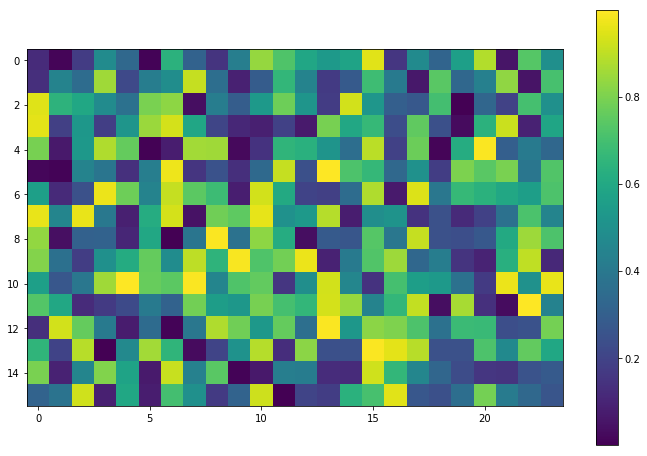

In [26]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float64)
b = np.random.random(test_size).astype(np.float64)
c = np.empty_like(a)

fig = plt.figure(figsize = (12,8))
plt.imshow(a)
plt.colorbar()
plt.show()

In [10]:
print(a.shape)

(16, 24)


In [28]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float64)
b_g = GPUArray(b.shape, np.float64)
a_g.set(a)
b_g.set(b)

In [29]:
#Allocate output data
c_g = GPUArray(c.shape, np.float64)

In [30]:
# a.shape =  (rows, columns) --> [y,x]
domain_size = (a.shape[1],a.shape[0]) # Now domain size is [x,y]
block_size = (8,4,1) # This needs to be [x,y,z]
grid_size = (domain_size[0] // block_size[0], domain_size[0] // block_size[1], 1) # // is the integer division in modern python
print("Block size = " + str(block_size))
print("Grid size = " + str (grid_size))
print("Domain size = " + str(domain_size))

Block size = (8, 4, 1)
Grid size = (3, 6, 1)
Domain size = (24, 16)


In [31]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.29703283, 0.80200673, 0.98178084, 0.5272139 , 0.81238444,
        0.40456676, 1.49564626, 0.72982798, 0.55012218, 0.45186759,
        1.38649016, 1.04874032, 0.92905364, 1.52816642, 1.47330675,
        1.48767311, 0.88685143, 1.29034959, 0.96981829, 1.06136181,
        1.64457557, 1.04410062, 0.76707488, 1.22915037],
       [0.99344414, 0.90408999, 1.32562347, 1.6513321 , 0.40567415,
        1.24258151, 0.92543806, 1.23433622, 1.04843869, 0.99255462,
        0.59155433, 0.91681899, 0.76963717, 0.41996619, 0.79451232,
        1.42460093, 0.99404802, 0.57608555, 1.13504062, 1.16262768,
        1.3871116 , 1.1835904 , 1.04383698, 0.91897386],
       [1.07660249, 1.52889509, 1.16065472, 1.08222551, 0.42867118,
        1.58561619, 1.53657174, 0.60120753, 0.65384275, 0.54785049,
        1.48159821, 1.35301242, 0.59496736, 0.18215065, 1.38761526,
        0.5412617 , 0.30243392, 0.89668827, 1.35863599, 0.51925324,
        0.5021125 , 0.55787176, 1.11646436, 1.27924977],
       [1.267

In [32]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.29703283 0.80200673 0.98178084 0.5272139  0.81238444 0.40456676
  1.49564626 0.72982798 0.55012218 0.45186759 1.38649016 1.04874032
  0.92905364 1.52816642 1.47330675 1.48767311 0.88685143 1.29034959
  0.96981829 1.06136181 1.64457557 1.04410062 0.76707488 1.22915037]
 [0.99344414 0.90408999 1.32562347 1.6513321  0.40567415 1.24258151
  0.92543806 1.23433622 1.04843869 0.99255462 0.59155433 0.91681899
  0.76963717 0.41996619 0.79451232 1.42460093 0.99404802 0.57608555
  1.13504062 1.16262768 1.3871116  1.1835904  1.04383698 0.91897386]
 [1.07660249 1.52889509 1.16065472 1.08222551 0.42867118 1.58561619
  1.53657174 0.60120753 0.65384275 0.54785049 1.48159821 1.35301242
  0.59496736 0.18215065 1.38761526 0.5412617  0.30243392 0.89668827
  1.35863599 0.51925324 0.5021125  0.55787176 1.11646436 1.27924977]
 [1.26761209 0.45750174 0.69499276 0.37320867 0.9779909  1.4898611
  1.89142098 1.5192924  0.42259246 0.47522802 0.68240595 0.98707739
  0.56693294 1.24594483 1.095949   1.64

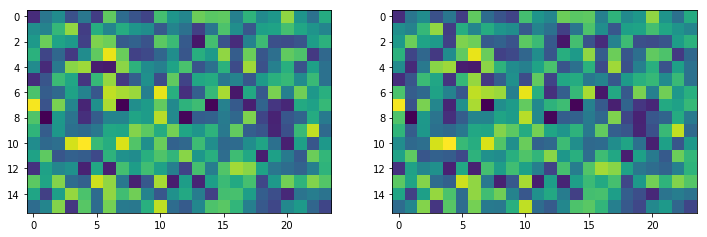

In [36]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(c_ref)